## Prompt-to-Prompt with Stable Diffusion

In [1]:
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import ptp_utils1
import seq_aligner
from PIL import Image

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update ```MY_TOKEN``` with your token.
Set ```LOW_RESOURCE``` to ```True``` for running on 12GB GPU.

In [15]:
MY_TOKEN = '<replace with your token>'
LOW_RESOURCE = False
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 8.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_id = "/home/data/ProtoGen_X3.4"

scheduler = DPMSolverMultistepScheduler.from_config(model_id,   # or use the v1-5 version
    subfolder="scheduler",
    solver_order=2,
    predict_epsilon=True,
    thresholding=False,
    algorithm_type="dpmsolver++",
    solver_type="midpoint",
    lower_order_final=True,
                                                   )  # the influence of this trick is effective for small (e.g. <=10) steps)
scheduler.set_timesteps(num_inference_steps=25)

ldm_stable = StableDiffusionPipeline.from_pretrained(model_id, scheduler =scheduler, torch_dtype=torch.float16).to(device)
tokenizer = ldm_stable.tokenizer

/home/miko/miniconda3/envs/ldm/lib/python3.8/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/home/miko/miniconda3/envs/ldm/lib/python3.8/site-packages/diffusers/schedulers/scheduling_dpmsolver_multistep.py:146: FutureWarning: The `predict_epsilon` argument is deprecated and will be removed in version 0.11.0. Please make sure to instantiate your scheduler with `prediction_type` instead. E.g. `scheduler = DPMSolverMultistepScheduler.from_pretrained(<model_id>, prediction_type='epsilon')`.
  predict_epsilon = deprecate("predic

## Prompt-to-Prompt Attnetion Controllers
Our main logic is implemented in the `forward` call in an `AttentionControl` object.
The forward is called in each attention layer of the diffusion model and it can modify the input attnetion weights `attn`.

`is_cross`, `place_in_unet in ("down", "mid", "up")`, `AttentionControl.cur_step` help us track the exact attention layer and timestamp during the diffusion iference.


In [16]:
class LocalBlend:

    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

        
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base.type(torch.float32), self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer


In [17]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [18]:
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, negative_prompt=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator, negative_prompt=negative_prompt)
        print(latent.dtype)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils1.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE, negative_prompt = negative_prompt )
    ptp_utils.view_images(images)
    return images, x_t

In [39]:
# prompt #
person = "suren"
sex = "female"

negative_prompt =["fat, cross-eyed, canvas frame, cartoon, 3d, ((disfigured)), ((bad art)), gun, ((deformed)),watermarks, ((extra limbs)),words, double head, ((close up)),((b&w)), wierd colors, blurry, (((duplicate))), poo art, bad hands, ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))), out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck))), Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render",
"fat, cross-eyed, canvas frame, cartoon, 3d, ((disfigured)), ((bad art)), gun, ((deformed)),watermarks, ((extra limbs)),words, double head, ((close up)),((b&w)), wierd colors, blurry, (((duplicate))), poo art, bad hands, ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))), out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck))), Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render"]

prompt = [
    "is a beautiful mayan princess, retro",
    "as magical lolita girl",
    "as Ahri from league of legends",
    "as disney snow white",
    "as disney cinderella",
    "as disney ariel"
]

style = [" headshot, intricate, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, unreal engine 5, 8k, art by artgerm and greg rutkowski and alphonse mucha",
" headshot, digital art by eugene de blaas, ross tran, and nasreddine dinet, vibrant color scheme, intricately detailed, in the style of romanticism, cinematic, artstation, greg rutkowski",
" shinkai makoto studio ghibli studio key hideaki anno sakimichan stanley artgerm lau rossdraws james jean marc simonetti elegant highly detailed digital painting artstation pixiv",
" headshot, fine details by stanley artgerm lau, wlop, rossdraws, james jean, andrei riabovitchev, marc simonetti, and sakimichan, tranding on artstation",
" By Greg Rutkowski, Ilya Kuvshinov, WLOP, Stanley Artgerm Lau, Ruan Jia and Fenghua Zhong, trending on ArtStation, made in Maya, Blender and Photoshop, octane render, precise correct anatomy, aesthetic",
"d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve",
]


In [24]:
# load lora #
model_dir = "meinv_suren"


monkeypatch_lora(ldm_stable.unet, torch.load("./out_"+model_dir+"/lora_weight.pt"))

monkeypatch_lora(ldm_stable.text_encoder, torch.load("./out_"+model_dir+"/lora_weight.text_encoder.pt"), target_replace_module=["CLIPAttention"])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_16509/3016075055.py:5 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_16509/3016075055.py'                        │
│                                                                                                  │
│ /home/miko/project/prompt-to-prompt/lora_diffusion/lora.py:145 in monkeypatch_lora               │
│                                                                                                  │
│   142 ):                                                                                         │
│   143 │   for _module in model.modules():                                                        │
│   144 │   │   if _module.__class__.__name__ in target_replace_module:                            │
│ ❱ 145 │   │   │   for name, _child_module in _module.named_modules():                            │
│   146 │   │   │   │   if _child_module.__class__.__name__ == "Linear":                           │
│   147 │   │   │   │   │                                                                          │
│   148 │   │   │   │   │   weight = _child_module.weight                                          │
│                                                                                                  │
│ /home/miko/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/nn/modules/module.py:1813 in    │
│ named_modules                                                                                    │
│                                                                                                  │
│   1810 │   │   │   if remove_duplicate:                                                          │
│   1811 │   │   │   │   memo.add(self)                                                            │
│   1812 │   │   │   yield prefix, self                                                            │
│ ❱ 1813 │   │   │   for name, module in self._modules.items():                                    │
│   1814 │   │   │   │   if module is None:                                                        │
│   1815 │   │   │   │   │   continue                                                              │
│   1816 │   │   │   │   submodule_prefix = prefix + ('.' if prefix else '') + name                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: OrderedDict mutated during iteration

In [ ]:
tune_lora_scale(ldm_stable.unet, 0)
tune_lora_scale(ldm_stable.text_encoder, 0)

## Cross-Attention Visualization
First let's generate an image and visualize the cross-attention maps for each word in the prompt.
Notice, we normalize each map to 0-1.

  0%|          | 0/50 [00:00<?, ?it/s]

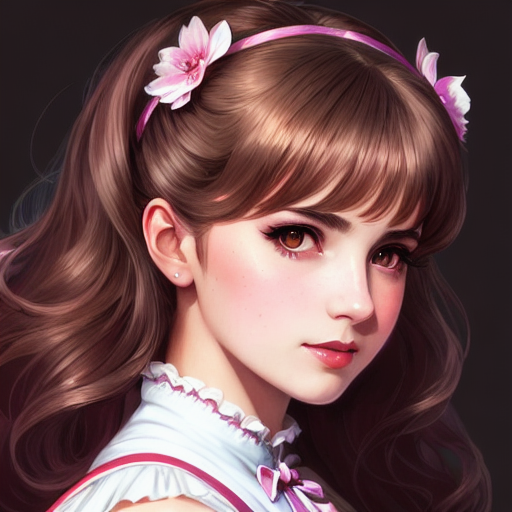

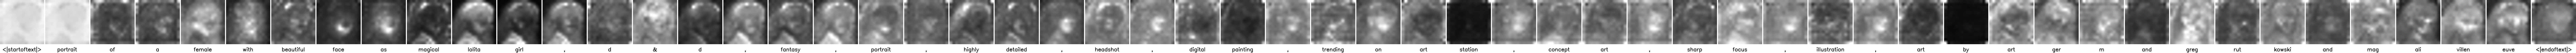

In [29]:
g_cpu = torch.Generator().manual_seed(1495009790)
prompts = ["Portrait of a female with beautiful face as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu, negative_prompt = negative_prompt)
show_cross_attention(controller, res=16, from_where=("up", "down"))

In [45]:
tune_lora_scale(ldm_stable.unet, 0.32)
tune_lora_scale(ldm_stable.text_encoder, 0.16)

## Replacement edit

w.o. prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

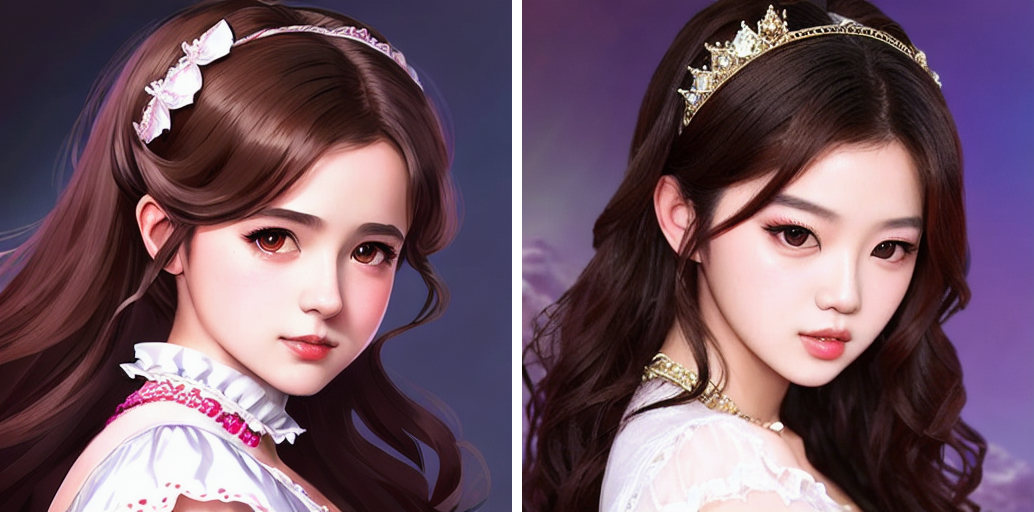

torch.float16
with prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

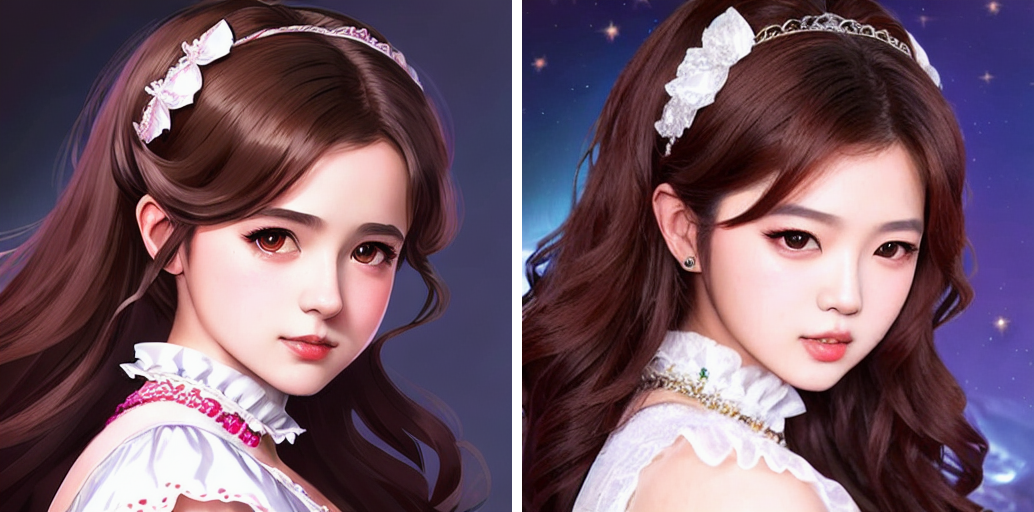

In [46]:
prompts = ["Portrait of a female as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve",
           "Portrait of a female with suren face as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve"]

controller = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.3, self_replace_steps=0.2)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=True, negative_prompt = negative_prompt)


In [ ]:
g_cpu = torch.Generator().manual_seed(1495009790)
prompts = ["Portrait of a female with beautiful face as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu, negative_prompt = negative_prompt)
show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
prompts = ["Portrait of a female with beautiful face as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve",
           "Portrait of a female with suren face as magical lolita girl,d & d, fantasy, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve"]
lb = LocalBlend(prompts, ("beautiful face", "suren face"))
controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS,
                              cross_replace_steps={"default_": 1., "suren": .3},
                              self_replace_steps=0.2, local_blend=lb)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=True)